# Wykorzystanie uczenia pół-nadzorowanego, uzupełnienie kategorii
## Opis zadania
* Uczenie pół-nadzorowane do celów uzupełnienia info o kategoriach
* Więcej niż tylko jedna metoda, ale z dobrym wytłumaczeniem dlaczego stosują
taką metodę a nie inną
* Porównanie metod, wybór jednej z nich
* OCENA (15%)
 * 8% pierwsza metoda (z wytłumaczeniem)
 * 4% druga metoda (z wytłumaczeniem)
 * 3% porównanie metod, wybór jednej

## Code

### Constants

In [0]:
DATA_FILE = 'data_checkpoint4.csv'
RANDOM_STATE = 1996

In [0]:
!pip install imbalanced-learn # imblearn

In [0]:
from google.colab import drive # Google Drive connection
from joblib import Memory # Memmory cache

# Pandas
import pandas as pd
# progress_apply
from tqdm.auto import tqdm  
tqdm.pandas()

from os import cpu_count
from os import path # joinging path
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style 
import seaborn as sns

# Scikit
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import ParameterGrid
from copy import deepcopy
from sklearn.semi_supervised import LabelSpreading
from sklearn.metrics import f1_score

# imblearn
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks

# disable warnings
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [0]:
style.use('seaborn-poster') 
style.use('ggplot')

In [0]:
if not(RANDOM_STATE == None):
  np.random.seed(RANDOM_STATE)

## Google Drive

In [0]:
# Mount google drive and load data
drive.mount('/content/drive')

drive_path = "/content/drive/My Drive/"
data_path = path.join(drive_path , 'datasets/youtube_data')
image_path = path.join(data_path, 'images')
cache_path = path.join(drive_path, 'cache')

# Set cache
memory = Memory(location=cache_path, verbose=0)

In [0]:
df = pd.read_csv(path.join(data_path, DATA_FILE))

In [0]:
df.shape

(8606, 915)

We work with:
 * 8k examples
 * 900 features

In [0]:
df.category_id = pd.Categorical(df.category_id)

## Test-Train split

Constants

In [0]:
TEST_SIZE = 0.2

In [0]:
df_cat = df.loc[df.category_id.notna()]

In [0]:
df_cat.shape

(448, 915)

In [0]:
print("%.2f%% of examples have category" % (len(df_cat)/len(df) * 100))

5.21% of examples have category


In [0]:
def show_values_on_bars(axs, h_v="v", space=0.4, fontsize=15):
  def _none_to_zero(val):
    return val if not(np.isnan(val)) else 0

  def _show_on_single_plot(ax):
    if h_v == "v":
      for p in ax.patches:
        _x = _none_to_zero(p.get_x() + p.get_width() / 2)
        _y = _none_to_zero(p.get_y() + p.get_height())
        value = int(_none_to_zero(p.get_height()))
        ax.text(_x, _y, value, ha="center", fontsize=fontsize) 
    elif h_v == "h":
      for p in ax.patches:
        _x = _none_to_zero(p.get_x() + p.get_width() + float(space))
        _y = _none_to_zero(p.get_y() + p.get_height())
        value = int(_none_to_zero(p.get_width()))
        ax.text(_x, _y, value, ha="left", fontsize=fontsize)

  if isinstance(axs, np.ndarray):
    for idx, ax in np.ndenumerate(axs):
        _show_on_single_plot(ax)
  else:
    _show_on_single_plot(axs)

We have ony 450 examples with category which constitue 5.21% in total

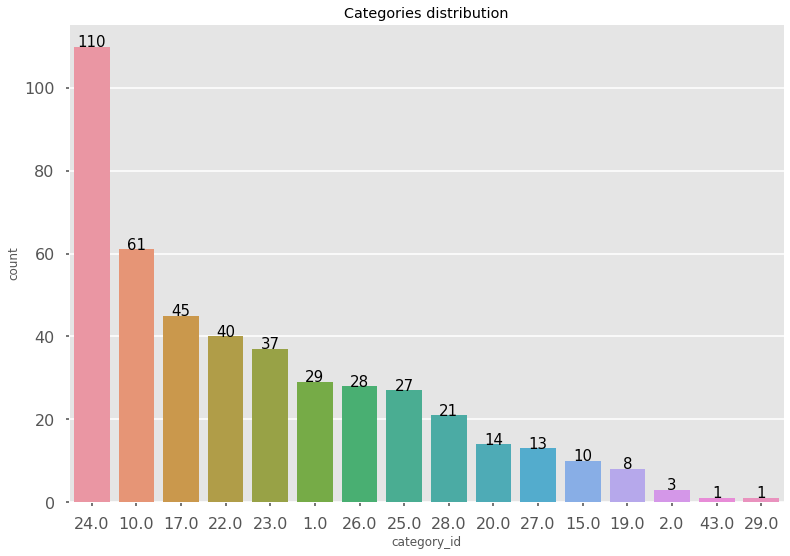

In [0]:
ax = sns.countplot(df_cat.category_id, 
                   order=df_cat.category_id.value_counts().index)
ax.set_title('Categories distribution')
show_values_on_bars(ax);

* The data is also highly imbalanced.  
* Two classes: **43** and **29** have also just one example. They will be duplicated to create splits with **Scikit** (a trick to utilize library methods). They will be later removed from the test and validation set, since we can't measure the performance on those classes anyway.

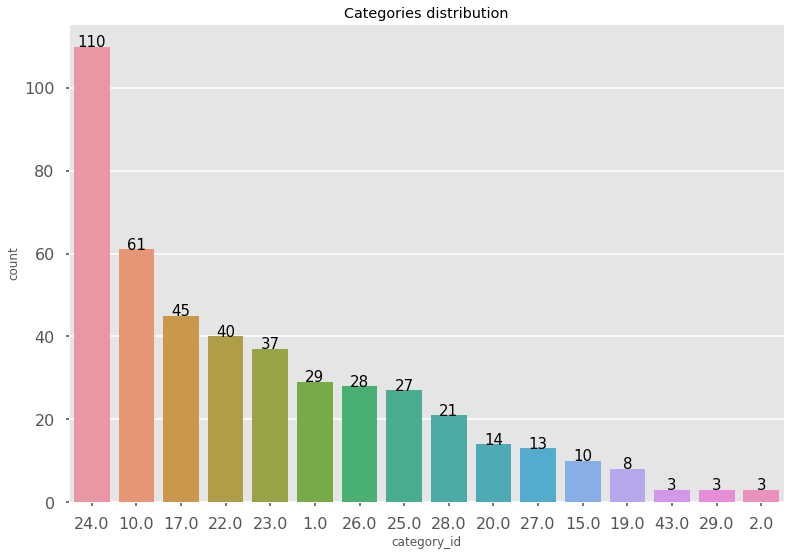

In [0]:
classes = df_cat.category_id.value_counts()
rare_classes = [k for k, v in classes.items() if v == 1]
rare_examples = df_cat.loc[df_cat.category_id.isin(rare_classes)]
df_cat = df_cat.append(rare_examples).append(rare_examples)

ax = sns.countplot(df_cat.category_id, 
                  order=df_cat.category_id.value_counts().index)
ax.set_title('Categories distribution')
show_values_on_bars(ax);

In [0]:
X = df_cat.drop(columns=['category_id']).to_numpy()
y = df_cat.loc[:,'category_id'].to_numpy()

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    stratify=y,
                                                    test_size=TEST_SIZE)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                    stratify=y_train,
                                                    test_size=TEST_SIZE)

In [0]:
def compare_cat_dist(y_train, y_test, y_valid=None, order=None):
  plt.figure(figsize=(25,15))

  df_train = pd.DataFrame(y_train, columns=['category'])
  df_train['data_set'] = 'train'

  df_test = pd.DataFrame(y_test, columns=['category'])
  df_test['data_set'] = 'test'

  df_valid = None
  if np.any(y_valid != None):
    df_valid = pd.DataFrame(y_valid, columns=['category'])
    df_valid['data_set'] = 'valid'

  df_y = df_train.append(df_test)
  if np.any(df_valid != None):
    df_y = df_y.append(df_valid)

  ax = sns.countplot(data=df_y, x='category', hue='data_set', order=order)
  ax.set_title('Category distribution');
  show_values_on_bars(ax);

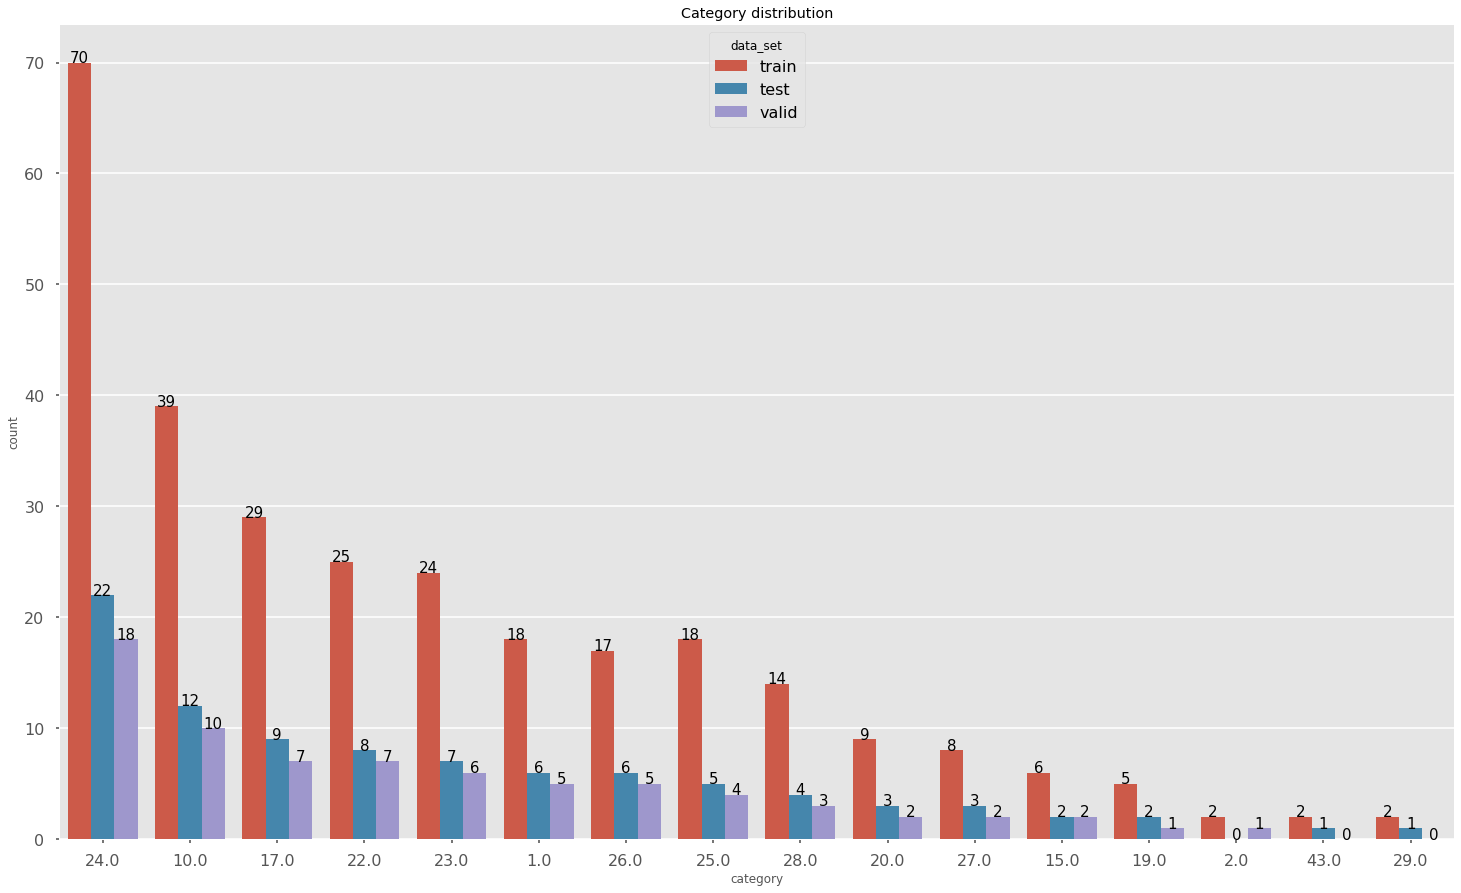

In [0]:
compare_cat_dist(y_train, y_test, y_val, order=df.category_id.value_counts().index)

Categry **2** is not represented in the _test set_. We will mannually move one example.  
We will also remove classes **43** and **29** from the _test set_. We will train the classifier on them but we won't measure the performance on them. Two other soultions (completly discarding those classes or including them in the test set and not in the training set) seem much less reasonable because of obvious reasons.

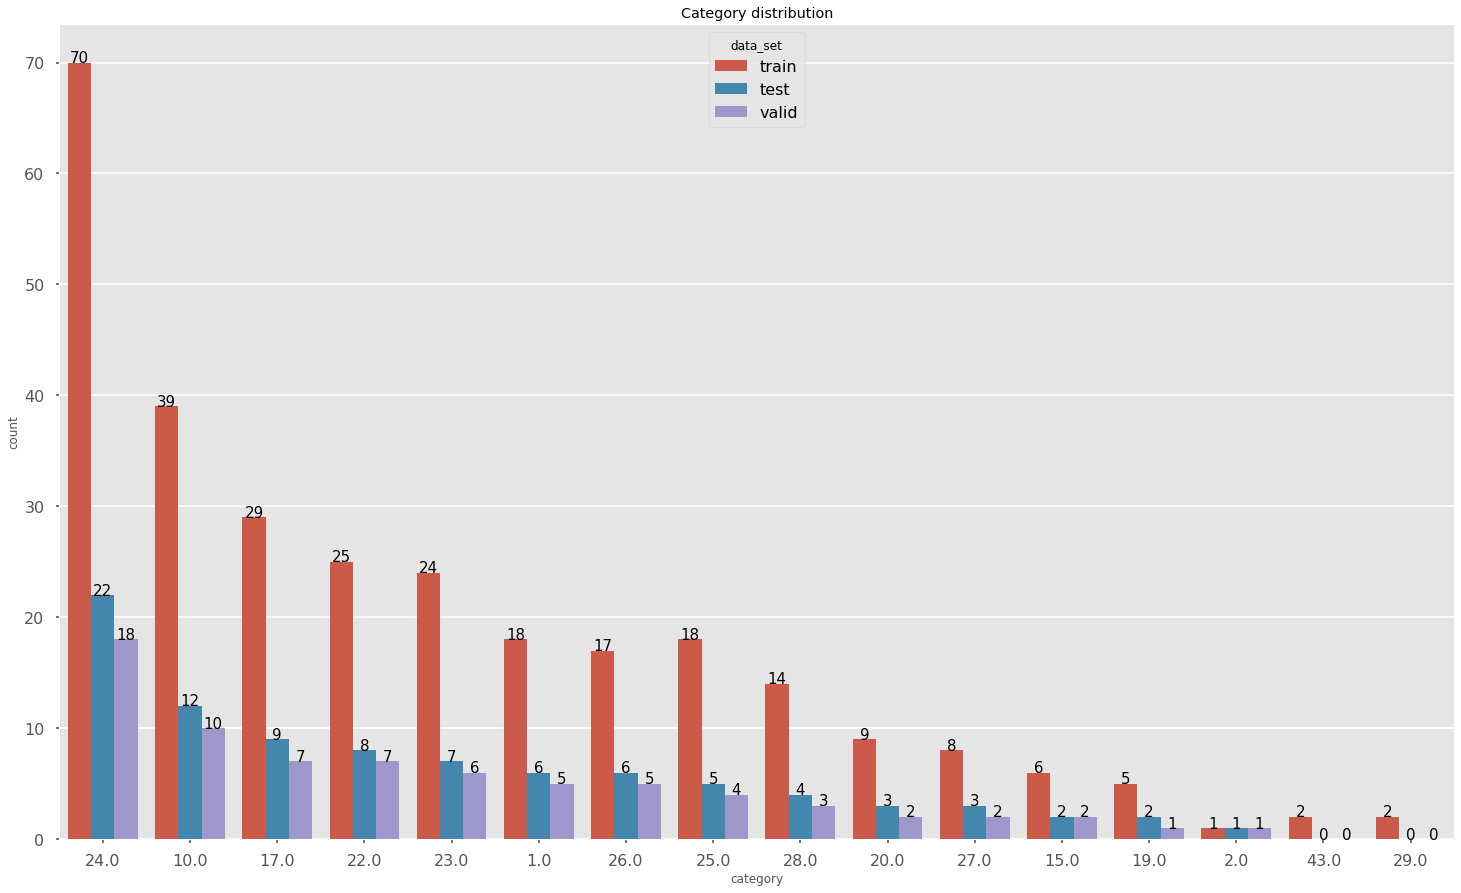

In [0]:
index = np.argmax(y_train==2.0)

X_test = np.append(X_test, X_train[index,None], axis=0) 
y_test = np.append(y_test, 2.0)

y_train = np.delete(y_train, index)
X_train = np.delete(X_train, index, axis=0)

to_remove = np.where(np.isin(y_test, [43.0, 29.0]))
X_test = np.delete(X_test, to_remove, axis=0)
y_test = np.delete(y_test, to_remove)
compare_cat_dist(y_train, y_test, y_val, order=df.category_id.value_counts().index)

## Imbalanced learning
Simple **Logistic regression** will be used as a reference classifier

In [0]:
class ClfScorer:
  
  SINGLE_SCORE_AVG = 'weighted avg'
  SINGLE_SCORE_MEASURE = 'f1-score'
  BENCHMARK_CLF = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)

  def __init__(self, X_test, y_test):
    self.X_test = X_test
    self.y_test = y_test
  
  def score_report(self, clf):
    print(type(clf))
    y_pred = clf.predict(self.X_test)
    report = classification_report(
        self.y_test, 
        y_pred,
        zero_division=0)
    print(report)
    
  def score_number(self, clf, ret=False, X=None, y=None):
    if X is None or y is None:
      X, y = self.X_test, self.y_test
    if not(ret): 
      print(type(clf))
    y_pred = clf.predict(X)
    report = classification_report(
        y,
        y_pred,
        zero_division=0,
        output_dict=True
    )
    score = report[self.SINGLE_SCORE_AVG][self.SINGLE_SCORE_MEASURE]
    if not(ret): 
      print('%s %s: %.2f' % (self.SINGLE_SCORE_AVG, 
                           self.SINGLE_SCORE_MEASURE, 
                           score))
    return score

  def train_and_score(self, X_train, y_train, clf=None):
    clf = clf if clf != None else self.BENCHMARK_CLF
    clf = self.BENCHMARK_CLF.fit(X_train, y_train)
    self.score_number(clf)

In [0]:
scorer = ClfScorer(X_val, y_val)
scorer.train_and_score(X_train, y_train)

<class 'sklearn.linear_model._logistic.LogisticRegression'>
weighted avg f1-score: 0.47


### Oversampling

Here naive **oversampling** will be applied

In [0]:
ros = RandomOverSampler(random_state=RANDOM_STATE)
X_res, y_res = ros.fit_resample(X_train, y_train)
scorer.train_and_score(X_res, y_res)

<class 'sklearn.linear_model._logistic.LogisticRegression'>
weighted avg f1-score: 0.46


As it was supposed, naive oversampling didn't improve the result. The score even got worse.

### SMOTE

In order to perform **SMOTE** first all the minority classes are randomly oversampled to 6.

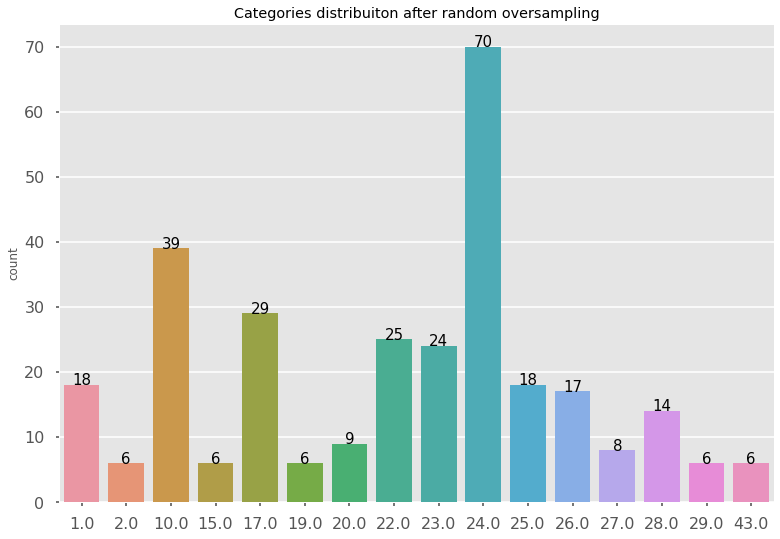

In [0]:
rare_classes = [19.0, 2.0, 43.0, 29.0]
sampling = {k : 6 for k in rare_classes}
X_res, y_res = RandomOverSampler(sampling_strategy=sampling,
                                 random_state=RANDOM_STATE)\
                .fit_resample(X_train, y_train)
ax = sns.countplot(y_res);
show_values_on_bars(ax);
ax.set_title('Categories distribuiton after random oversampling');

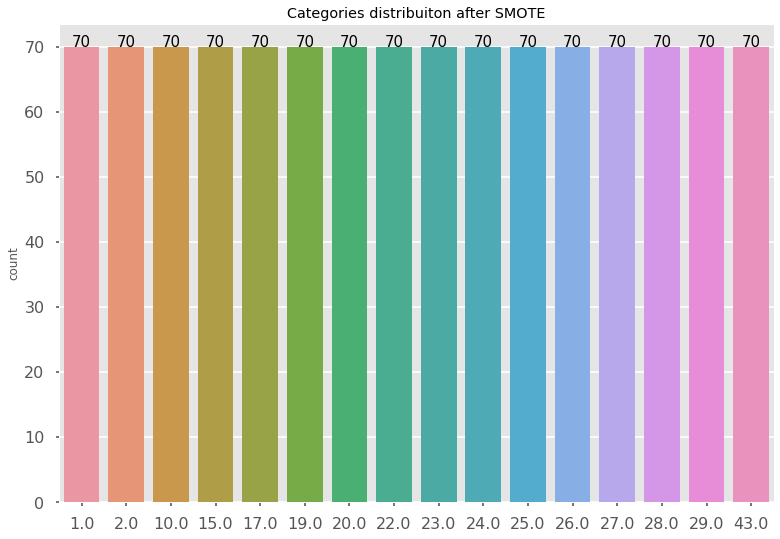

In [0]:
X_res, y_res = SMOTE(random_state=RANDOM_STATE).fit_resample(X_res, y_res);
ax = sns.countplot(y_res);
show_values_on_bars(ax);
ax.set_title('Categories distribuiton after SMOTE');

In [0]:
scorer.train_and_score(X_res, y_res)

<class 'sklearn.linear_model._logistic.LogisticRegression'>
weighted avg f1-score: 0.47


**SMOTE** improved the score by **1%**

### Tomek Links

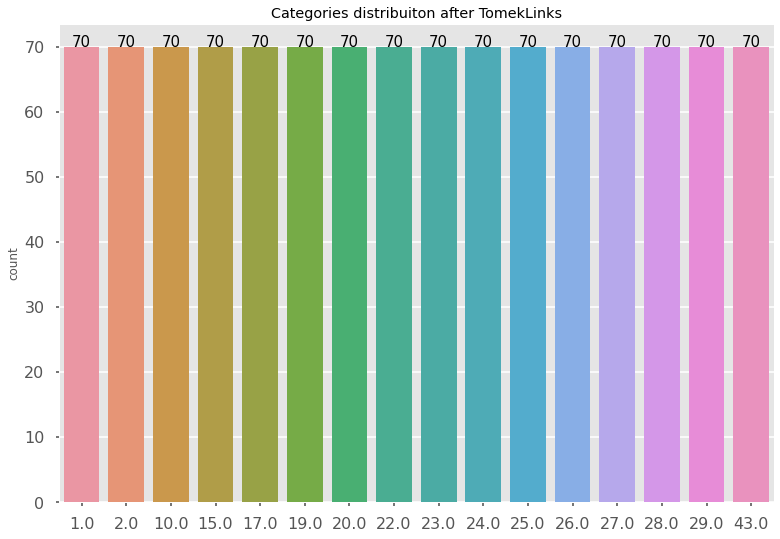

In [0]:
X_tom, y_tom = TomekLinks(random_state=RANDOM_STATE).fit_resample(X_res, y_res);
ax = sns.countplot(y_res);
show_values_on_bars(ax);
ax.set_title('Categories distribuiton after TomekLinks');

As we can see, no _Tomek Links_ were found.

## Semi-Supervised Learning

The first _semi-supervised_ method that will be aplied is **self-learning**.
The method was chosen for the following purposes:
 * Ease of implementation
 * Low number of _hyperparameters_
 * Classifier independence

Because of very high **feature space** it was decided to use relatively simple classifier - **Logistic Regression**. In order to combat overfitting which is surely to happen **l2 regularization** will be applied.

**Self learning** will be applied in the following manner:
* Every iteration some of the most sure predictions by the terms of **softmax outputs** and determined by the **threshold** will be added to the training set
* Meanwhile the **validation** score will be measured. 
* The iterations will be executed until the _validation score_ drops. 
* The best saved classifier will be returned. 

The two _hyperparameters_:
* _l2_ regularization **C**
* _self learning's_ **threshold** 
will be crossvalidated on the _validation set_.

After selecting the best set of hyperparameters the _validation_ and _training_ sets will be merged and the final classifier will be trained and the performance will be measured on the _test_ set.


### Self-Learning

In [0]:
class SelfLearning:
  def __init__(self, clf, X, y, unlabeled, threshold=0.99, verbose=True,
               scorer=None, score=False, max_iter=None, max_decreasing=3):
    self.clf = clf
    self.X = X.copy()
    self.y = y.copy()
    self.unlabeled = unlabeled.copy()
    self.threshold = threshold
    self.new_confident = True
    self.verbose = verbose
    self.scorer = scorer
    self.score = scorer != None
    self.scores = {
        'valid': [],
        'train': []
    }
    self.max_iter = max_iter
    self.n_iter = 0
    self.max_decreasing = max_decreasing
    self._n_decreased = 0
    self._best_clf = None

    if score and scorer == None:
      raise RuntimeError("Set scorer")

  def self_learn(self, n_iter=None):
    self._log('Self learning with %s' % str(type(clf)))
    self._fit()
    self._best_clf = deepcopy(self.clf)
    self._log()
    while self.new_confident:
      self.n_iter += 1
      self._log('Iteration %3d:' % self.n_iter, end=' ')
      self._fit()
      self._add_confident()
      self._log('', end='\n')
      if self.max_iter == self.n_iter:
        break
      if self._reached_max_dec():
        break
    return self._best_clf

  def _reached_max_dec(self):
    return self.max_decreasing and self._n_decreased >= self.max_decreasing

  def _fit(self):
    self.clf.fit(self.X, self.y)
    self._add_score()

  def _log(self, msg='', end='\n'):
    if self.verbose:
      print(msg, end=end)

  def _add_score(self):
    if not(self.score):
      return
    valid_metric = self.scorer.score_number(self.clf, ret=True)
    if len(self.scores['valid']) > 0 and self.scores['valid'][-1] > valid_metric:
      self._n_decreased +=1
    else:
      self._n_decreased = 0
      self._best_clf = deepcopy(self.clf) 
    self.scores['valid'].append(valid_metric)
    train_metric = self.scorer.score_number(self.clf, 
                                            ret=True, 
                                            X=self.X, 
                                            y=self.y)
    self.scores['train'].append(train_metric)
    self._log('train_score: %.2f val_score: %.2f' 
              % (train_metric, valid_metric), end= ' ')

  def _add_confident(self):
    probs = self.clf.predict_proba(self.unlabeled)
    index = np.argmax(probs, axis=1)
    rows = np.choose(index, probs.T) > self.threshold
    self.new_confident = np.any(rows)
    if not(self.new_confident):
      self._log('learning finished')
      return
    if self.verbose: print('new examples: %3d' % sum(rows), end=' ')
    X_new = self.unlabeled[rows,:]
    y_new = self.clf.predict(self.unlabeled)[rows]
    self.X = np.append(self.X, X_new, axis=0)
    self.y = np.append(self.y, y_new)
    self.unlabeled = np.delete(self.unlabeled, np.where(rows), axis=0) 
  
  def plot_scores(self, title=''):
    plt.plot(self.scores['train']);
    plt.plot(self.scores['valid'])
    plt.legend(['train', 'valid'])
    plt.xlabel('Iteration');
    plt.ylabel('F1-Score');
    plt.title(title);

#### Logistic Regression

In [0]:
unlabeled = df.loc[df.category_id.isna()].drop(columns=['category_id']).to_numpy()
scorer = ClfScorer(X_val, y_val)

parameters = {
  'C': 10.0**(-np.arange(0, 6)),
  'threshold': np.arange(0.7, 1, 0.05)
}
grid = ParameterGrid(parameters)
best_params = {'score': 0}

for params in grid:
  clf = LogisticRegression(max_iter=1000, 
                          n_jobs=cpu_count(), 
                          warm_start=True,
                          C=params['C'])
  
  selfLearning = SelfLearning(clf, 
                              X_res, 
                              y_res, 
                              unlabeled, 
                              scorer=scorer,
                              threshold=params['threshold'],
                              max_decreasing=1,
                              verbose=True)
  clf = selfLearning.self_learn()
  score = scorer.score_number(clf, ret=True)
  if score > best_params['score']:
    best_params['score'] = score
    best_params['params'] = params
    print('Best params: ', best_params)
  else:
    print(params, score)

Self learning with <class 'sklearn.linear_model._logistic.LogisticRegression'>
train_score: 1.00 val_score: 0.47 
Iteration   1: train_score: 1.00 val_score: 0.47 new examples: 4300 
Iteration   2: train_score: 1.00 val_score: 0.50 new examples: 2565 
Iteration   3: train_score: 1.00 val_score: 0.46 new examples: 810 
Best params:  {'score': 0.49943011458794656, 'params': {'C': 1.0, 'threshold': 0.7}}
Self learning with <class 'sklearn.linear_model._logistic.LogisticRegression'>
train_score: 1.00 val_score: 0.47 
Iteration   1: train_score: 1.00 val_score: 0.47 new examples: 3789 
Iteration   2: train_score: 1.00 val_score: 0.49 new examples: 2588 
Iteration   3: train_score: 1.00 val_score: 0.50 new examples: 921 
Iteration   4: train_score: 1.00 val_score: 0.51 new examples: 320 
Iteration   5: train_score: 1.00 val_score: 0.52 new examples: 147 
Iteration   6: train_score: 1.00 val_score: 0.52 new examples:  72 
Best params:  {'score': 0.517628140504853, 'params': {'C': 1.0, 'thresh

In [0]:
print(best_params)

{'score': 0.5230069062462294, 'params': {'C': 0.001, 'threshold': 0.7}}


Self learning with logistic regression achieved the average weighted f1 score of 52% with _C = 0.001_ and _threshold = 0.7_.  
At this stage _train_ and _validation_ sets will be merged and the whole pipeline will be applied to the merged set


In [0]:
X_all = np.append(X_res, X_val, axis=0)
y_all = np.append(y_res, y_val)

In [0]:
scorer = ClfScorer(X_test, y_test)
unlabeled = df.loc[df.category_id.isna()].drop(columns=['category_id']).to_numpy()

clf = LogisticRegression(max_iter=1000, 
                        n_jobs=cpu_count(), 
                        warm_start=True,
                        C=0.001)

selfLearning = SelfLearning(clf, 
                            X_all, 
                            y_all, 
                            unlabeled, 
                            scorer=scorer,
                            threshold=0.7,
                            max_decreasing=1,
                            verbose=True)
clf = selfLearning.self_learn()

Self learning with <class 'sklearn.linear_model._logistic.LogisticRegression'>
train_score: 0.98 val_score: 0.54 
Iteration   1: train_score: 0.98 val_score: 0.54 new examples: 253 
Iteration   2: train_score: 0.98 val_score: 0.52 new examples: 394 


In [0]:
print('Test set:')
test_scorer = ClfScorer(X_test, y_test)
test_scorer.score_number(clf)
print('Train set:')
train_scorer = ClfScorer(X_all, y_all)
train_scorer.score_number(clf);

Test set:
<class 'sklearn.linear_model._logistic.LogisticRegression'>
weighted avg f1-score: 0.54
Train set:
<class 'sklearn.linear_model._logistic.LogisticRegression'>
weighted avg f1-score: 0.99


We finally achieved _weighted averaged f1-score_ of **54%** on the _test set_. We can clearly see, that the classifier is overfitting despite the regularization applied: it achieved the score of **99%** on the _training set_.  The reason of this behaviour could be the high number of features (**914**), compared to the low number of training samples (**448** before applying any _augumentation/unsupervised learning_ techniques).

### Label Spreading

The second semi-supervised method is **Label Spreading**. This choice was motivated by:
 * fast training
 * few hyperparameters to set
 * ready-to-use implementation in *scikit* 

Label Spreading is an graph algotihm where a node’s labels propagate to all nodes according to their proximity. *LabelSpreading* minimizes a loss function that has regularization properties. The algorithm iterates on a modified version of the original graph and normalizes the edge weights by computing the normalized graph Laplacian matrix. - by [scikit](https://scikit-learn.org/stable/modules/label_propagation.html#label-propagation)

Parameters:
 * gamma - parameter for *rbf* kernel
 * max_iter - maximum number of iterations allowed
 * alpha - clamping factor - specifies the relative amount that an instance should adopt the information from its neighbors as opposed to its initial label

*Scikit* also allows to choose kernel - *RBF* or *KNN*. After performing few preparatory tests, it turned out that *KNN* gives much worse results and is much slower, so we chose to test further only *RBF*.



In [0]:
class LabelProp:
  def __init__(self, X_train, y_train, unlabeled):
    self.X_train = X_train
    self.y_train = y_train
    self.unlabeled = unlabeled.copy()
    self.unlabeled = unlabeled.drop("category_id", axis=1)
    self.unlabeled.columns = list(np.arange(len(self.unlabeled.columns)))
    self.unlabeled['category_id'] = -1*np.ones((len(self.unlabeled)))
    self.model = None
  
  def train(self, gamma, max_iter, alpha):
    X = pd.DataFrame(X_train)
    X['category_id'] = y_train
    X = pd.concat([X, self.unlabeled], axis=0)
    X = X.sample(frac=1)
    Y = X.iloc[:,-1]
    X = X.iloc[:, :-1]
    self.model = LabelSpreading(gamma=gamma, max_iter=max_iter, alpha=alpha)
    self.model.fit(X, Y)

  def predict(self, X_test):
    if self.model is None:
      print("ERROR. No model")
    else:
      return self.model.predict(X_test)

We will test some parameters with grid search and choose parameters, which give best results.


In [0]:
parameters = {
  'gamma': [0.01, 0.02, 0.1],
  'max_iter': [5, 10, 30],
  'alpha': [0.1, 0.2, 0.5]
}
grid = ParameterGrid(parameters)

for params in grid:
  labelProp = LabelProp(X_res, y_res, df.loc[df.category_id.isna()])
  labelProp.train(gamma=params['gamma'], max_iter=params['max_iter'], alpha=params['alpha'])
  y_pred = labelProp.predict(X_val)
  print(" gamma: ", params['gamma'], " max_iter: ", params['max_iter'], " alpha: ", params['alpha'], 
        " score: ", f1_score(y_val, y_pred, average='weighted'))

 gamma:  0.01  max_iter:  5  alpha:  0.1  score:  0.3966882432635857
 gamma:  0.01  max_iter:  10  alpha:  0.1  score:  0.3966882432635857
 gamma:  0.01  max_iter:  30  alpha:  0.1  score:  0.3966882432635857
 gamma:  0.02  max_iter:  5  alpha:  0.1  score:  0.4738282677256825
 gamma:  0.02  max_iter:  10  alpha:  0.1  score:  0.4738282677256825
 gamma:  0.02  max_iter:  30  alpha:  0.1  score:  0.4738282677256825
 gamma:  0.1  max_iter:  5  alpha:  0.1  score:  0.3919255782269481
 gamma:  0.1  max_iter:  10  alpha:  0.1  score:  0.3919255782269481
 gamma:  0.1  max_iter:  30  alpha:  0.1  score:  0.3919255782269481
 gamma:  0.01  max_iter:  5  alpha:  0.2  score:  0.3966882432635857
 gamma:  0.01  max_iter:  10  alpha:  0.2  score:  0.3966882432635857
 gamma:  0.01  max_iter:  30  alpha:  0.2  score:  0.3966882432635857
 gamma:  0.02  max_iter:  5  alpha:  0.2  score:  0.48701857279617156
 gamma:  0.02  max_iter:  10  alpha:  0.2  score:  0.48701857279617156
 gamma:  0.02  max_iter:  

We will train classifier with best parameters on the training + validation set and then test it on the test set.

In [0]:
labelProp = LabelProp(X_all, y_all, df.loc[df.category_id.isna()])
labelProp.train(gamma=0.02, max_iter=5, alpha=0.2)

In [0]:
print('Test set:')
y_test_pred = labelProp.predict(X_test)
print(f1_score(y_test, y_test_pred, average='weighted'))
print('Train set:')
y_train_pred = labelProp.predict(X_all)
print(f1_score(y_all, y_train_pred, average='weighted'));

Test set:
0.4349259999259999
Train set:
0.9704004986398205


As we can see, in spite of regularization included in *LabelSpreading*, the classifier is strongly overfitted.

### Method choice

The first method - **Self Learning** obtained better results for the test set - 52% in comparison to **Label Spreading** - only 43%. 

Label Spreading was much faster than Self Learning, however. 

Both methods use regularization, but still problem with overfitting is present. Self learning can be used with different classifiers, therefore it is more flexible.

With main criterion, which is weighted score on F1 metric, we choose to use **Self Learning** with **Logistic Regression** in further considerations.